<a href="https://colab.research.google.com/github/SEBIN6/Ayna_Assignment/blob/main/inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import zipfile
import os

!unzip -q dataset.zip -d dataset

replace dataset/dataset/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## Import Libraries and Define Classes

In [10]:
import os
import random
import numpy as np
from PIL import Image
import json
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision.transforms.functional as TF


class PolygonColorDataset(Dataset):

    def __init__(self, root_dir, transform=None):
        self.input_dir = os.path.join(root_dir, "inputs")
        self.output_dir = os.path.join(root_dir, "outputs")
        self.transform = transform

        with open(os.path.join(root_dir, "data.json")) as f:
            self.data = json.load(f)


        self.color_map = {
            "red": [1, 0, 0],
            "green": [0, 1, 0],
            "blue": [0, 0, 1],
            "yellow": [1, 1, 0],
            "cyan": [0, 1, 1],
            "magenta": [1, 0, 1],
            "black": [0, 0, 0],
            "white": [1, 1, 1],
            "orange": [1, 0.5, 0],
            "purple": [0.5, 0, 0.5],
        }

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]

        input_name = item.get("input_polygon") or item.get("input") or item.get("input_file")
        output_name = item.get("output_image") or item.get("output") or item.get("output_file")
        color_name = item.get("colour") or item.get("color")

        if input_name is None or output_name is None or color_name is None:
            raise KeyError(f"Missing expected keys in data item: {item}")

        input_path = os.path.join(self.input_dir, input_name)
        output_path = os.path.join(self.output_dir, output_name)

        if not os.path.exists(input_path):
            raise FileNotFoundError(f"Input image not found: {input_path}")
        if not os.path.exists(output_path):
            raise FileNotFoundError(f"Output image not found: {output_path}")


        input_img = Image.open(input_path).convert("L")  # Grayscale
        output_img = Image.open(output_path).convert("RGB")  # Target colored


        if self.transform:
            input_img = self.transform(input_img)
            output_img = self.transform(output_img)
        else:
            to_tensor = T.ToTensor()
            input_img = to_tensor(input_img)
            output_img = to_tensor(output_img)


        color_key = color_name.lower()
        if color_key not in self.color_map:
            print(f"Warning: color '{color_name}' not in map, defaulting to black")
            color_vec = torch.tensor(self.color_map["black"], dtype=torch.float32)
        else:
            color_vec = torch.tensor(self.color_map[color_key], dtype=torch.float32)

        return input_img, color_vec, output_img

class UNet(nn.Module):
    """
    The UNet model architecture for image-to-image translation.
    It takes a grayscale image and a color vector as input to produce a colored image.
    """
    def __init__(self, input_channels=4, output_channels=3):
        super(UNet, self).__init__()

        # Helper function to create a standard convolutional block
        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, 3, padding=1),
                nn.ReLU(inplace=True)
            )


        self.enc1 = conv_block(input_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = conv_block(128, 256)


        self.up1 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec1 = conv_block(256, 128)
        self.up2 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec2 = conv_block(128, 64)

        # Final output layer
        self.final = nn.Conv2d(64, output_channels, 1)

    def forward(self, x, color):
        B, _, H, W = x.shape
        color_map = color.view(B, 3, 1, 1).expand(B, 3, H, W)
        x = torch.cat([x, color_map], dim=1)

        # Encoder forward pass
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))

        # Decoder forward pass with skip connections
        d1 = self.up1(e3)
        d1 = torch.cat([d1, e2], dim=1)
        d1 = self.dec1(d1)

        d2 = self.up2(d1)
        d2 = torch.cat([d2, e1], dim=1)
        d2 = self.dec2(d2)

        return self.final(d2)

print("Class definitions loaded.")


Class definitions loaded.


## Load Model and Data

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = T.Compose([
    T.Resize((128, 128)),
    T.ToTensor(),
])

model = UNet().to(device)
model.load_state_dict(torch.load("unet_model.pth", map_location=device))
model.eval()

test_ds = PolygonColorDataset("dataset/dataset/validation", transform)
test_loader = DataLoader(test_ds, batch_size=1)

## Perform Inference and Visualize a Random Sample

Performing inference on a random sample from the test set...


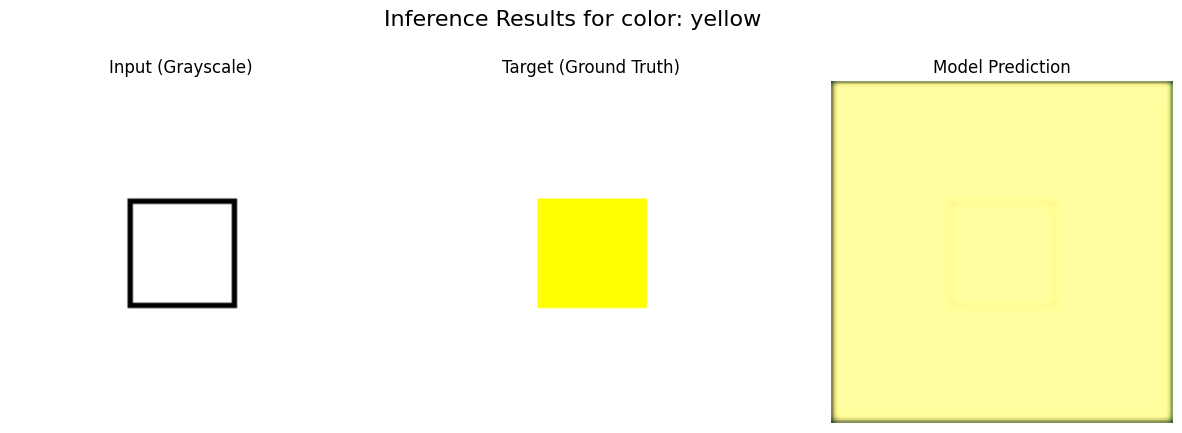

Inference complete.


In [13]:
print("Performing inference on a random sample from the test set...")
if len(test_ds) > 0:
    sample_idx = random.randint(0, len(test_ds) - 1)
    input_img_tensor, color_vec_tensor, target_img_tensor = test_ds[sample_idx]

    input_img_tensor = input_img_tensor.unsqueeze(0).to(device)
    color_vec_tensor = color_vec_tensor.unsqueeze(0).to(device)
    target_img_tensor = target_img_tensor.unsqueeze(0).to(device)

    with torch.no_grad():
        prediction_tensor = model(input_img_tensor, color_vec_tensor)

    def tensor_to_image(tensor):
        tensor = tensor.cpu().squeeze(0).clamp(0, 1)
        return T.ToPILImage()(tensor)

    input_image = tensor_to_image(input_img_tensor)
    target_image = tensor_to_image(target_img_tensor)
    predicted_image = tensor_to_image(prediction_tensor)

    sample_item = test_ds.data[sample_idx]
    color_name = sample_item.get("colour") or sample_item.get("color")

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f"Inference Results for color: {color_name}", fontsize=16)

    ax[0].imshow(input_image, cmap='gray')
    ax[0].set_title("Input (Grayscale)")
    ax[0].axis('off')

    ax[1].imshow(target_image)
    ax[1].set_title("Target (Ground Truth)")
    ax[1].axis('off')

    ax[2].imshow(predicted_image)
    ax[2].set_title("Model Prediction")
    ax[2].axis('off')

    plt.show()

    print("Inference complete.")